In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"parsahosseinalizadeh","key":"fa9013c477056a1ec01042028fddcc32"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download birdy654/eeg-brainwave-dataset-feeling-emotions

Dataset URL: https://www.kaggle.com/datasets/birdy654/eeg-brainwave-dataset-feeling-emotions
License(s): copyright-authors
  0% 0.00/11.9M [00:00<?, ?B/s]
100% 11.9M/11.9M [00:00<00:00, 1.42GB/s]


In [7]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import LambdaLR
import math
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


tf.random.set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [5]:
with ZipFile("/content/eeg-brainwave-dataset-feeling-emotions.zip", "r") as f:
    f.extractall("/content")
    f.close()

In [8]:
df = pd.read_csv("/content/emotions.csv")
df.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,mean_d_0_a2,mean_d_1_a2,mean_d_2_a2,mean_d_3_a2,mean_d_4_a2,mean_d_5_a,mean_d_6_a,mean_d_7_a,mean_d_8_a,mean_d_9_a,mean_d_10_a,mean_d_11_a,mean_d_12_a,mean_d_13_a,mean_d_14_a,mean_d_15_a,mean_d_16_a,mean_d_17_a,mean_d_18_a,mean_d_19_a,mean_d_20_a,mean_d_21_a,mean_d_22_a,mean_d_23_a,mean_d_24_a,mean_d_25_a,mean_d_26_a,mean_d_27_a,mean_d_28_a,mean_d_29_a,...,fft_711_b,fft_712_b,fft_713_b,fft_714_b,fft_715_b,fft_716_b,fft_717_b,fft_718_b,fft_719_b,fft_720_b,fft_721_b,fft_722_b,fft_723_b,fft_724_b,fft_725_b,fft_726_b,fft_727_b,fft_728_b,fft_729_b,fft_730_b,fft_731_b,fft_732_b,fft_733_b,fft_734_b,fft_735_b,fft_736_b,fft_737_b,fft_738_b,fft_739_b,fft_740_b,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,2.15,29.5,-353.0,14.40,21.5,5.98,30.7,-343.0,14.7,27.9,3.17,32.2,-368.0,15.9,36.4,7.08,28.8,-359.0,17.3,19.6,-3.8300,-1.230,-10.80000,-0.363,-6.41,-1.03,-2.780,14.60,-1.540,-14.900000,...,30.90,-24.4,-24.4,30.90,-442.0,388.0,-197.0,-197.0,388.0,-564.0,500.00,-245.00,-245.00,500.00,-88.8,214.0,-88.8,-88.8,214.0,-606.0,509.000,-261.0,-261.0,509.000,-399.0,374.0,-185.00,-185.00,374.0,74.3,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,25.60,32.8,29.6,21.50,17.4,25.50,31.7,31.5,26.2,32.9,31.80,33.1,33.2,28.5,26.8,32.40,34.7,33.8,27.0,14.2,0.0342,1.100,-1.87000,-4.690,-15.40,-6.22,-0.328,-3.53,-6.980,-9.370000,...,-5.99,-19.1,-19.1,-5.99,163.0,-11.0,-10.7,-10.7,-11.0,117.0,-3.93,17.90,17.90,-3.93,112.0,-13.9,25.5,25.5,-13.9,225.0,-0.968,-27.7,-27.7,-0.968,97.4,-19.0,40.70,40.70,-19.0,130.0,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,7.75,30.1,-441.0,9.89,25.3,-68.90,25.3,-481.0,-65.4,20.0,79.80,31.0,-408.0,91.9,29.5,18.80,31.1,-335.0,32.2,19.9,76.6000,4.850,39.90000,75.300,5.27,-72.00,-0.843,-33.00,-82.000,-4.200000,...,585.00,-285.0,-285.0,585.00,-94.3,183.0,-110.0,-110.0,183.0,-133.0,200.00,-72.00,-72.00,200.00,-356.0,295.0,-158.0,-158.0,295.0,-251.0,255.000,-95.7,-95.7,255.000,-177.0,159.0,-48.80,-48.80,159.0,-534.0,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,17.30,32.0,-148.0,20.40,22.8,13.20,31.5,-147.0,16.9,27.7,15.70,30.7,-142.0,20.7,22.8,13.60,32.2,-135.0,21.2,23.8,4.1500,0.556,-0.35400,3.460,-4.96,1.63,1.330,-5.83,-0.298,0.000777,...,249.00,-146.0,-146.0,249.00,359.0,-146.0,13.7,13.7,-146.0,119.0,-7.64,-7.17,-7.17,-7.64,-296.0,316.0,-218.0,-218.0,316.0,322.0,-113.000,38.4,38.4,-113.000,245.0,-61.9,-5.08,-5.08,-61.9,-183.0,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,26.10,34.3,43.7,23.70,20.6,-3.87,34.1,43.7,-10.0,22.9,59.40,26.7,60.3,64.7,26.9,32.30,30.1,33.6,31.6,27.7,30.0000,0.276,-0.00677,33.700,-2.36,-33.30,7.640,-16.60,-41.100,-6.290000,...,18.30,-11.9,-11.9,18.30,159.0,-18.2,-25.6,-25.6,-18.2,194.0,32.70,-54.50,-54.50,32.70,154.0,26.4,-56.4,-56.4,26.4,252.0,9.940,-37.4,-37.4,9.940,172.0,15.9,-7.25,-7.25,15.9,114.0,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2132 entries, 0 to 2131
Columns: 2549 entries, # mean_0_a to label
dtypes: float64(2548), object(1)
memory usage: 41.5+ MB


In [10]:
for i in df.columns:
    if (df[i].isna().sum() > 0):
        print(i)
else:
    print("No null columns. Good to go!!!")

No null columns. Good to go!!!


In [11]:
df.duplicated().sum()

np.int64(0)

In [12]:
df["label"].value_counts()

,count
label,
NEUTRAL,716
NEGATIVE,708
POSITIVE,708


In [13]:
df["label"] = df["label"].apply(lambda x: {"NEUTRAL": 0, "NEGATIVE":1, "POSITIVE":2}[x])

In [14]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1:].copy()

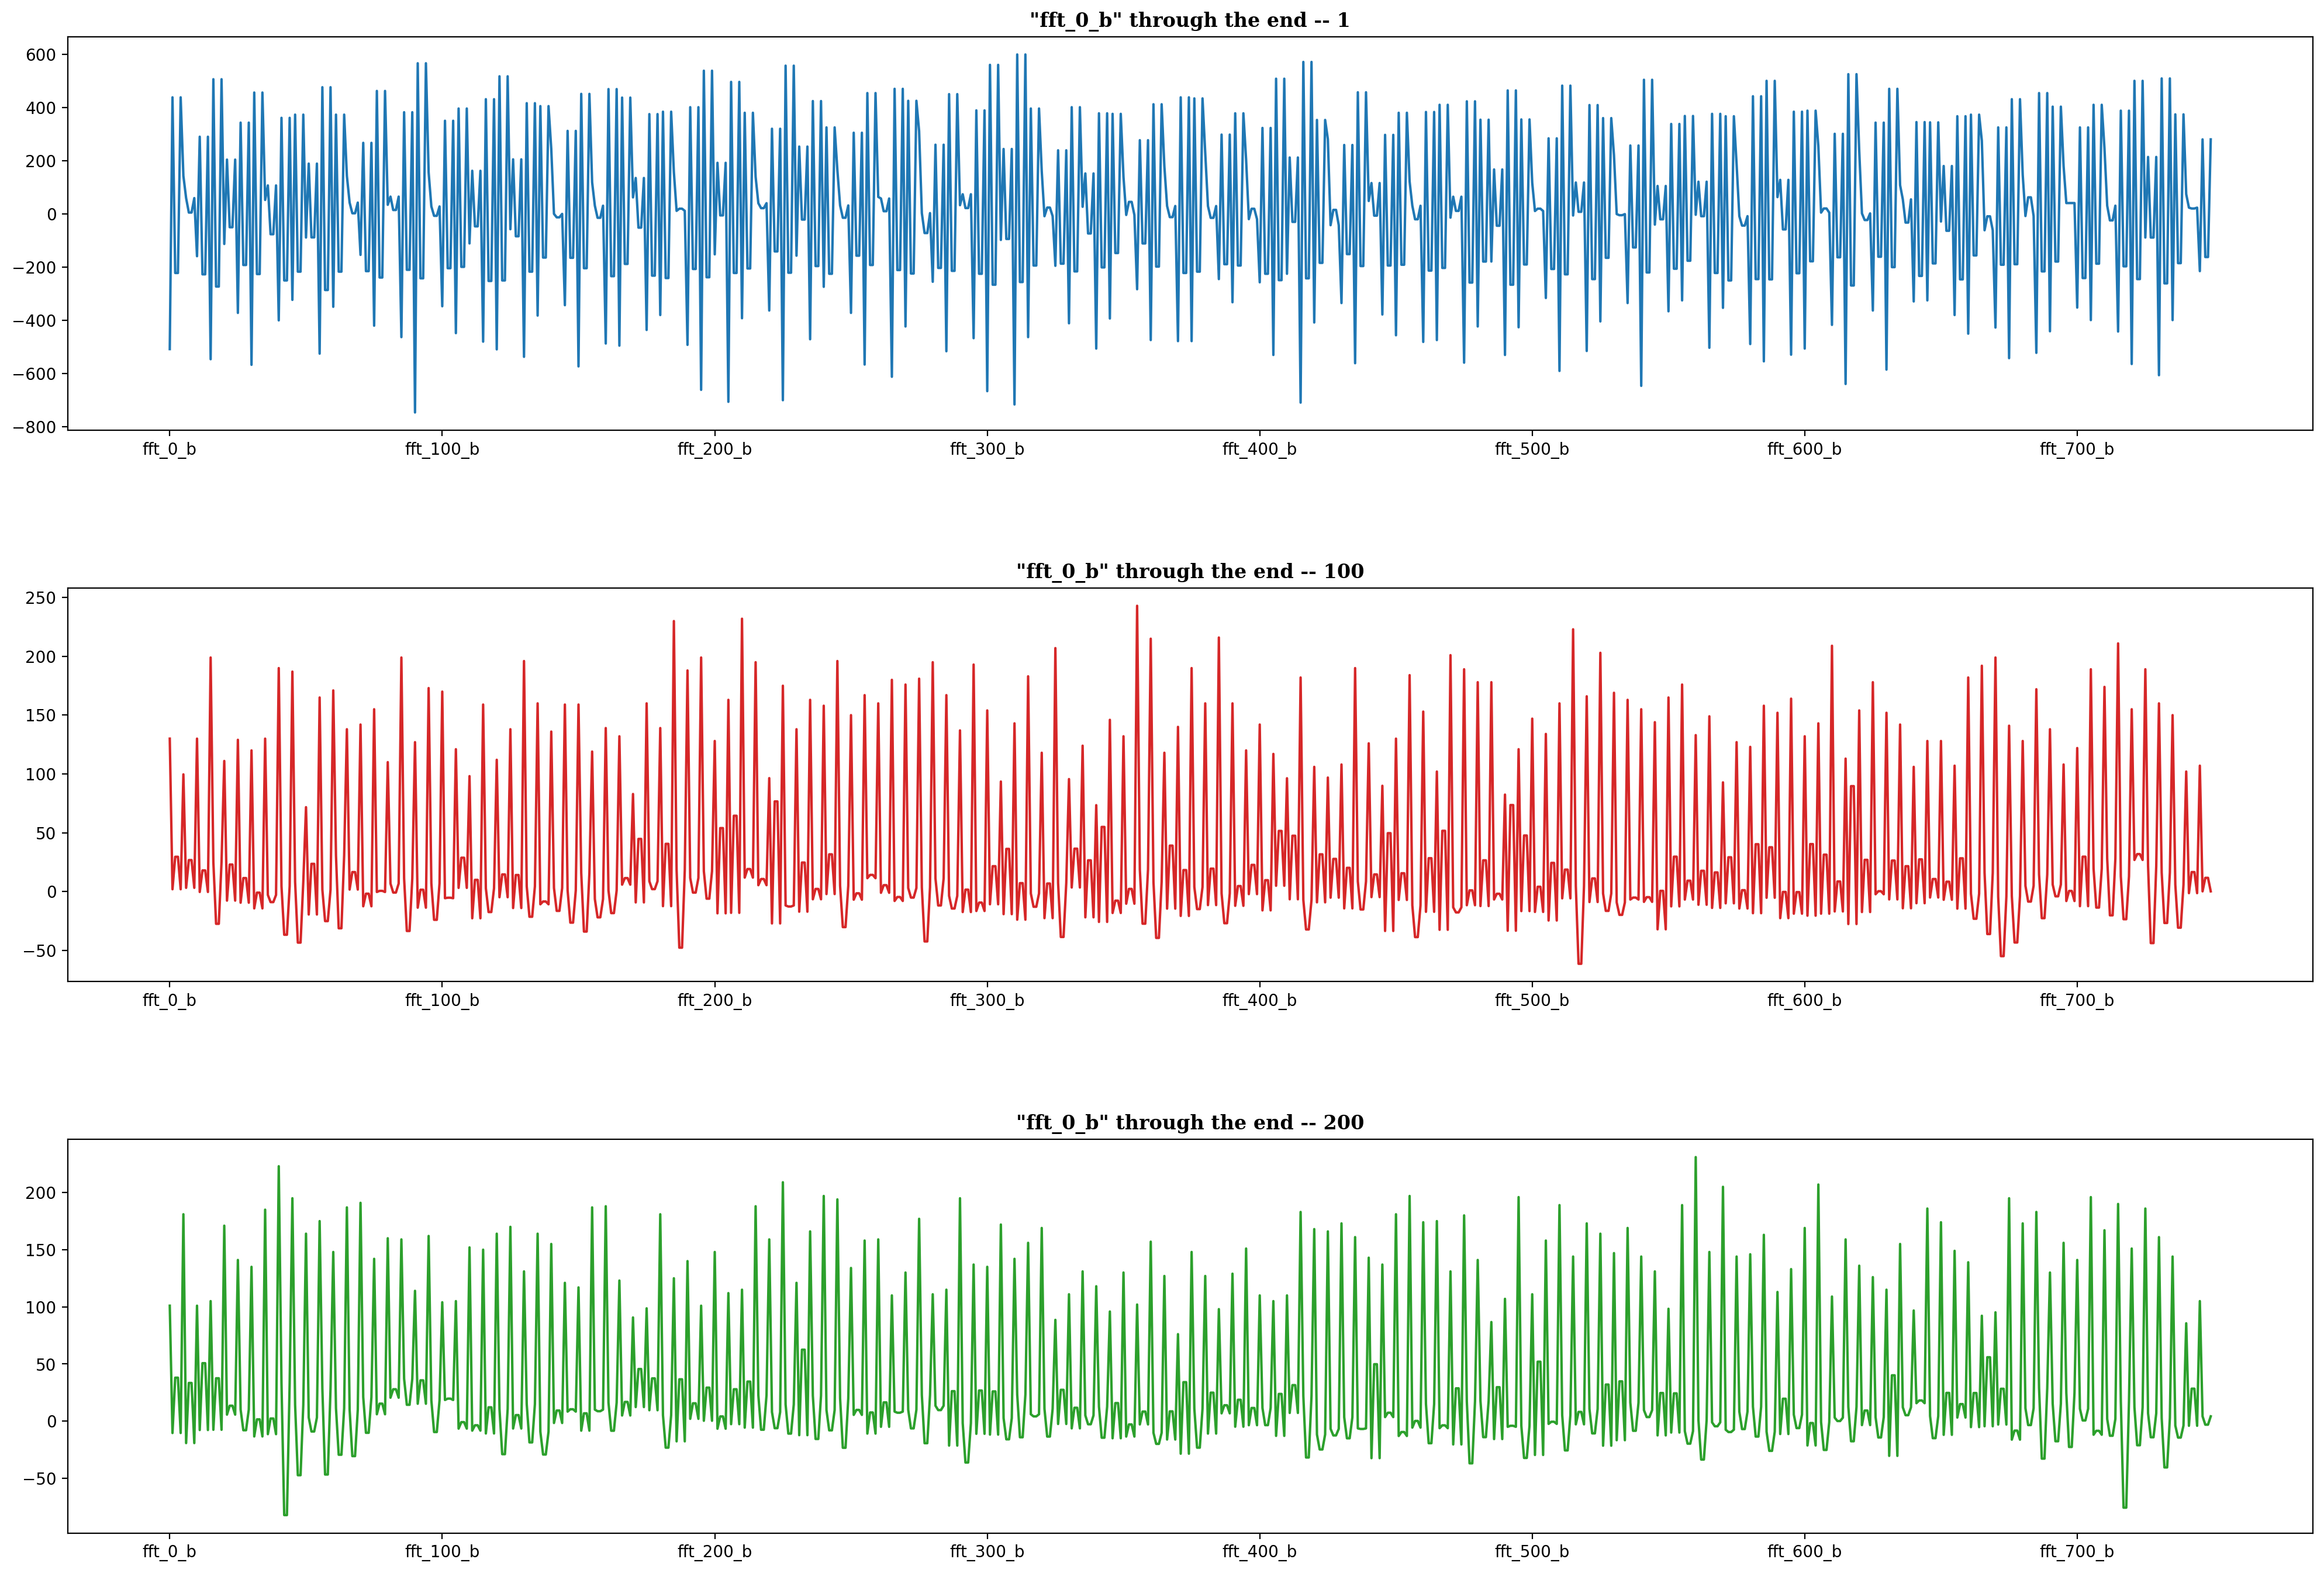

In [15]:
fontdict = {"family":"Serif", "size": 12, "weight":"bold"}

fig, axes = plt.subplots(nrows=3, ncols=1, dpi=200, figsize=(24, 16))

X.iloc[0, X.columns.get_loc("fft_0_b") : ].plot(color='tab:blue', ax=axes[0])
axes[0].set_title('"fft_0_b" through the end -- 1', fontdict=fontdict)

X.iloc[99, X.columns.get_loc("fft_0_b") : ].plot(color='tab:red', ax=axes[1])
axes[1].set_title('"fft_0_b" through the end -- 100', fontdict=fontdict)

X.iloc[199, X.columns.get_loc("fft_0_b") : ].plot(color='tab:green', ax=axes[2])
axes[2].set_title('"fft_0_b" through the end -- 200', fontdict=fontdict)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()


In [16]:
class Early_stopping:
    def __init__(self,  patience=10, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = float("inf")
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


class GRU(nn.Module):
    def __init__(self, hidden_size=256, seq_len=2548, n_classes=3, num_layers=4):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.n_classes = n_classes

        self.gru = nn.GRU(input_size = 1,
                          hidden_size = self.hidden_size,
                          batch_first = True,
                          num_layers=num_layers)
        self.fc = nn.Linear(hidden_size * seq_len, n_classes)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out.reshape(out.size(0), -1)
        logits = self.fc(out)
        return logits


class LSTM(nn.Module):
    def __init__(self, hidden_size=256, num_classes=3, num_layers=4):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1,
                            hidden_size = hidden_size,
                            batch_first=True,
                            num_layers=4)

        self.fc = nn.Linear(hidden_size * 2548, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out.reshape(out.size(0), -1)
        logits = self.fc(out)
        return logits


class CNN_GRU(nn.Module):
    def __init__(self, n_classes=3):
        super(CNN_GRU, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=10)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3)
        self.conv3 = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.gru = nn.GRU(input_size=16, hidden_size=256, batch_first=True)
        self.fc = nn.Linear(in_features=256, out_features=n_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pool(x)
        x = x.permute(0, 2, 1)
        _, h = self.gru(x)
        h = h.squeeze(0)
        out = self.fc(h)
        return out


class CNN_LSTM(nn.Module):
    def __init__(self, n_classes=3):
        super(CNN_LSTM, self).__init__()
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=10)
        self.conv2 = nn.Conv1d(16, 16, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=16, hidden_size=256, batch_first=True)
        self.fc = nn.Linear(256, n_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.permute(0, 2, 1)
        _, (h_n, _) = self.lstm(x)
        h = h_n.squeeze(0)

        return self.fc(h)


In [17]:
def training_loop(model, features, labels, patience=10):
    early_stopping = Early_stopping(patience=patience)
    train_losses, val_losses= [], []
    train_accs, val_accs = [], []
    num_epochs = 50
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: math.exp(-epoch / 10.0))

    X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=111, test_size=0.3)
    X_train, X_val, y_train, y_val=train_test_split(X_train, y_train, random_state=111, test_size=0.3)

    X_train_t = torch.tensor(np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1)), dtype=torch.float32)
    y_train_t = torch.tensor(np.array(y_train).squeeze(), dtype=torch.long)

    X_test_t  = torch.tensor(np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1)), dtype=torch.float32)
    y_test_t  = torch.tensor(np.array(y_test).squeeze(), dtype=torch.long)

    X_val_t   = torch.tensor(np.array(X_val).reshape((X_val.shape[0], X_val.shape[1], 1)), dtype=torch.float32)
    y_val_t   = torch.tensor(np.array(y_val).squeeze(), dtype=torch.long)


    train_ds = TensorDataset(X_train_t, y_train_t)
    val_ds   = TensorDataset(X_val_t, y_val_t)
    test_ds  = TensorDataset(X_test_t, y_test_t)

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=32)
    test_loader  = DataLoader(test_ds, batch_size=32)


    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (preds.argmax(1) == yb).sum().item()
            total += yb.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        model.eval()
        val_running_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_running_loss += criterion(preds, yb).item()
                val_correct += (preds.argmax(1) == yb).sum().item()
                val_total += yb.size(0)
        val_loss = val_running_loss / len(val_loader)
        val_acc = val_correct / val_total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} | "
              f"LR: {scheduler.get_last_lr()[0]:.6f}")

        scheduler.step()

        # ---- Early stopping check ----
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered at epoch:", epoch+1)
            break


    model.eval()  # set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # no gradients needed
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device).view(-1).long()
            preds = model(xb)
            predicted_labels = preds.argmax(dim=1)  # get class with highest score
            correct += (predicted_labels == yb).sum().item()
            total += yb.size(0)

    test_accuracy = correct / total
    print("\n\n\ntesting the acc...")
    print(f"Test Accuracy: {test_accuracy*100:.4f}")

    return train_losses, val_losses, train_accs, val_accs, test_accuracy

def plot(train_losses, val_losses, train_accs, val_accs):
    fontdict1 = {"family":"Serif", "size": 12, "weight":"bold"}
    fontdict2 = {"family":"Serif", "size": 15, "weight":"bold"}
    epochs = range(1, len(train_losses)+1)

    plt.figure(figsize=(14,5))

    # --- Loss plot ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch', fontdict = fontdict1)
    plt.ylabel('Loss', fontdict = fontdict1)
    plt.title('Training vs Validation Loss', fontdict = fontdict2)
    plt.legend()
    plt.grid(True)

    # --- Accuracy plot ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch', fontdict = fontdict1)
    plt.ylabel('Accuracy', fontdict = fontdict1)
    plt.title('Training vs Validation Accuracy', fontdict = fontdict2)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    return plt.show()


In [18]:
cnn_lstm = CNN_LSTM().to(device)
cnn_lstm_outputs = training_loop(cnn_lstm, X, y)

Epoch 1/50 | Train Loss: 0.4300, Train Acc: 0.8582 | Val Loss: 0.3047, Val Acc: 0.8750 | LR: 0.001000
Epoch 2/50 | Train Loss: 0.2432, Train Acc: 0.9061 | Val Loss: 0.2583, Val Acc: 0.8839 | LR: 0.000905
Epoch 3/50 | Train Loss: 0.2025, Train Acc: 0.9243 | Val Loss: 0.2412, Val Acc: 0.9040 | LR: 0.000819
Epoch 4/50 | Train Loss: 0.1964, Train Acc: 0.9310 | Val Loss: 0.2305, Val Acc: 0.9129 | LR: 0.000741
Epoch 5/50 | Train Loss: 0.1922, Train Acc: 0.9301 | Val Loss: 0.2294, Val Acc: 0.9129 | LR: 0.000670
Epoch 6/50 | Train Loss: 0.1721, Train Acc: 0.9397 | Val Loss: 0.1920, Val Acc: 0.9129 | LR: 0.000607
Epoch 7/50 | Train Loss: 0.1627, Train Acc: 0.9387 | Val Loss: 0.1824, Val Acc: 0.9308 | LR: 0.000549
Epoch 8/50 | Train Loss: 0.1457, Train Acc: 0.9473 | Val Loss: 0.1881, Val Acc: 0.9263 | LR: 0.000497
Epoch 9/50 | Train Loss: 0.1331, Train Acc: 0.9531 | Val Loss: 0.1709, Val Acc: 0.9286 | LR: 0.000449
Epoch 10/50 | Train Loss: 0.1393, Train Acc: 0.9444 | Val Loss: 0.1650, Val Acc: 0

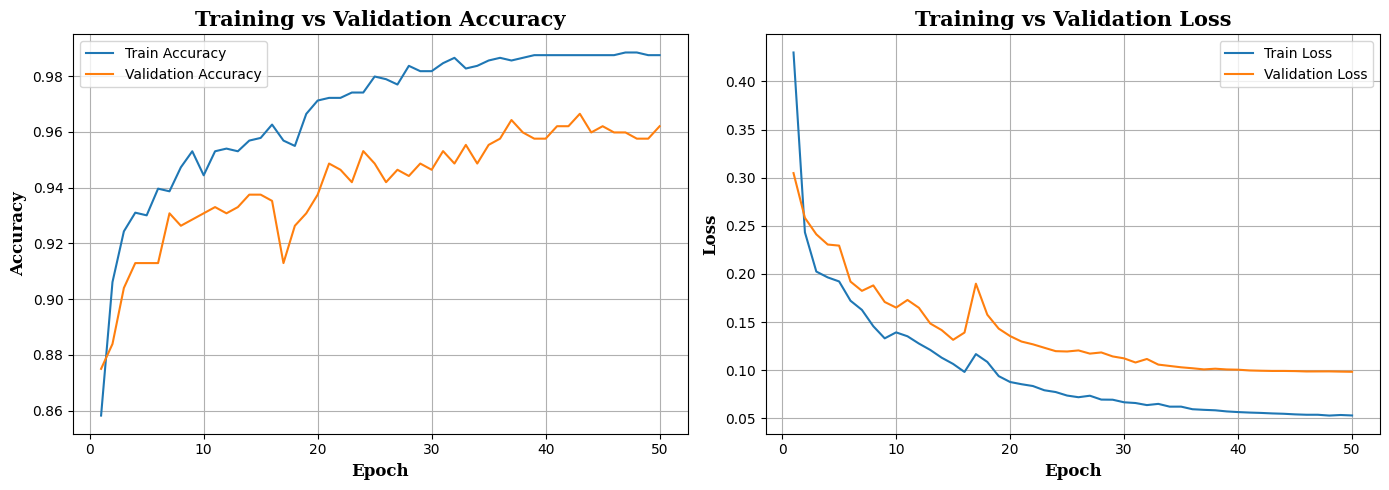

In [19]:
plot(cnn_lstm_outputs[0] ,cnn_lstm_outputs[1] ,cnn_lstm_outputs[2],cnn_lstm_outputs[3])

In [20]:
str(cnn_lstm_outputs[4]*100) + "%"

'94.53125%'

In [21]:
lstm_model = LSTM().to(device)
lstm_outputs = training_loop(lstm_model, X, y)

Epoch 1/50 | Train Loss: 2.6552, Train Acc: 0.6609 | Val Loss: 0.4618, Val Acc: 0.7388 | LR: 0.001000
Epoch 2/50 | Train Loss: 0.2578, Train Acc: 0.8956 | Val Loss: 0.2482, Val Acc: 0.8973 | LR: 0.000905
Epoch 4/50 | Train Loss: 0.1447, Train Acc: 0.9502 | Val Loss: 0.2047, Val Acc: 0.9263 | LR: 0.000741
Epoch 5/50 | Train Loss: 0.0678, Train Acc: 0.9789 | Val Loss: 0.1369, Val Acc: 0.9621 | LR: 0.000670
Epoch 6/50 | Train Loss: 0.0544, Train Acc: 0.9780 | Val Loss: 0.1290, Val Acc: 0.9665 | LR: 0.000607
Epoch 7/50 | Train Loss: 0.0322, Train Acc: 0.9933 | Val Loss: 0.1183, Val Acc: 0.9732 | LR: 0.000549
Epoch 9/50 | Train Loss: 0.0132, Train Acc: 0.9962 | Val Loss: 0.1296, Val Acc: 0.9688 | LR: 0.000449
Epoch 10/50 | Train Loss: 0.0084, Train Acc: 0.9990 | Val Loss: 0.1175, Val Acc: 0.9710 | LR: 0.000407
Epoch 11/50 | Train Loss: 0.0074, Train Acc: 0.9981 | Val Loss: 0.1256, Val Acc: 0.9732 | LR: 0.000368
Epoch 12/50 | Train Loss: 0.0035, Train Acc: 1.0000 | Val Loss: 0.1159, Val Acc:

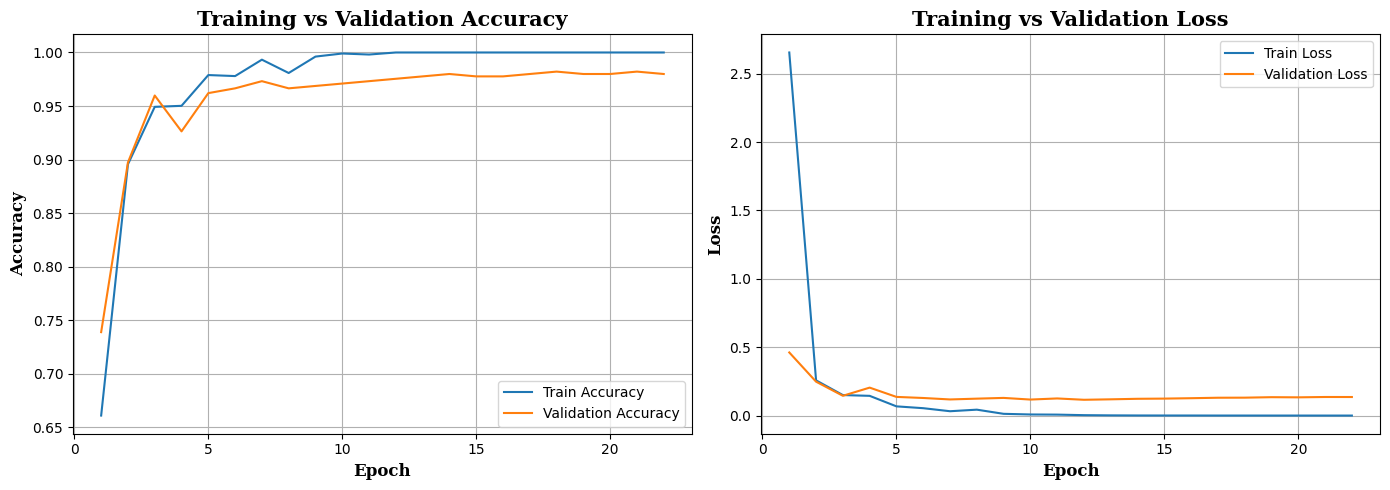

In [22]:
plot(lstm_outputs[0] ,lstm_outputs[1] ,lstm_outputs[2], lstm_outputs[3])

In [23]:
str(lstm_outputs[4]*100) + "%"

'97.8125%'

In [24]:
gru_model = GRU().to(device)
gru_outputs = training_loop(gru_model, X, y)

Epoch 1/50 | Train Loss: 6.3854, Train Acc: 0.7567 | Val Loss: 1.9710, Val Acc: 0.7500 | LR: 0.001000
Epoch 2/50 | Train Loss: 0.7895, Train Acc: 0.8946 | Val Loss: 0.5602, Val Acc: 0.9196 | LR: 0.000905
Epoch 3/50 | Train Loss: 0.3214, Train Acc: 0.9243 | Val Loss: 0.7849, Val Acc: 0.8214 | LR: 0.000819
Epoch 4/50 | Train Loss: 0.1875, Train Acc: 0.9406 | Val Loss: 0.2769, Val Acc: 0.9353 | LR: 0.000741
Epoch 5/50 | Train Loss: 0.1501, Train Acc: 0.9559 | Val Loss: 0.2151, Val Acc: 0.9531 | LR: 0.000670
Epoch 6/50 | Train Loss: 0.0189, Train Acc: 0.9933 | Val Loss: 0.1509, Val Acc: 0.9621 | LR: 0.000607
Epoch 7/50 | Train Loss: 0.0058, Train Acc: 1.0000 | Val Loss: 0.1500, Val Acc: 0.9754 | LR: 0.000549
Epoch 8/50 | Train Loss: 0.0037, Train Acc: 1.0000 | Val Loss: 0.1406, Val Acc: 0.9732 | LR: 0.000497
Epoch 9/50 | Train Loss: 0.0030, Train Acc: 1.0000 | Val Loss: 0.1442, Val Acc: 0.9732 | LR: 0.000449
Epoch 10/50 | Train Loss: 0.0025, Train Acc: 1.0000 | Val Loss: 0.1457, Val Acc: 0

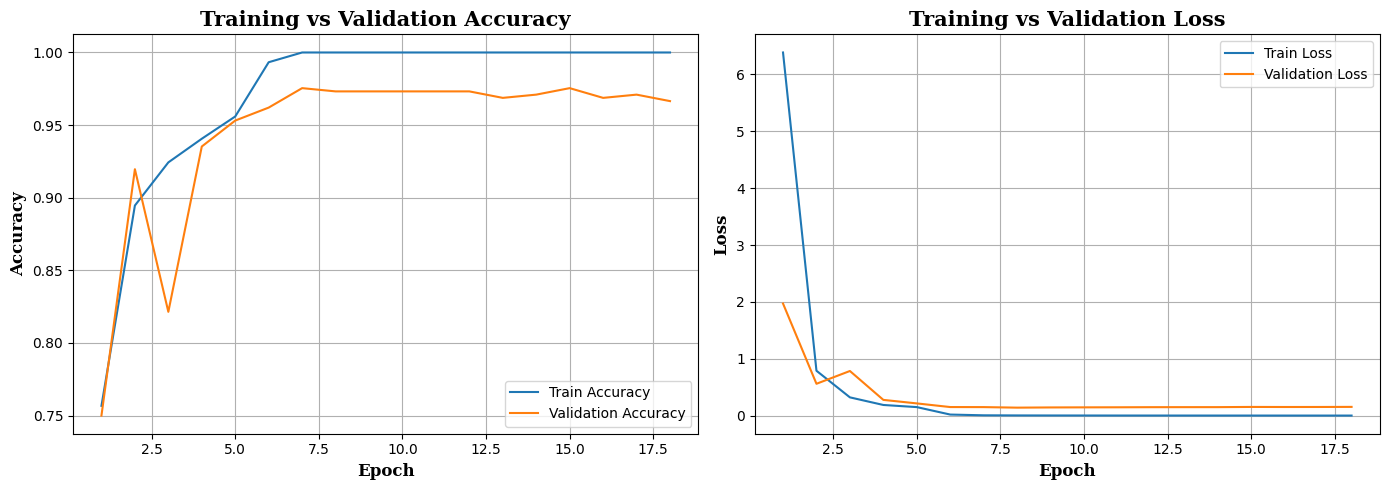

In [25]:
plot(gru_outputs[0], gru_outputs[1], gru_outputs[2], gru_outputs[3])

In [26]:
str(gru_outputs[4]*100)+"%"

'97.8125%'

In [27]:
cnn_gru = CNN_GRU().to(device)
cnn_gru_outputs = training_loop(cnn_gru, X, y)

Epoch 1/50 | Train Loss: 0.4694, Train Acc: 0.8170 | Val Loss: 0.3540, Val Acc: 0.8795 | LR: 0.001000
Epoch 2/50 | Train Loss: 0.2290, Train Acc: 0.9138 | Val Loss: 0.4459, Val Acc: 0.8571 | LR: 0.000905
Epoch 3/50 | Train Loss: 0.2098, Train Acc: 0.9157 | Val Loss: 0.2363, Val Acc: 0.8996 | LR: 0.000819
Epoch 4/50 | Train Loss: 0.1863, Train Acc: 0.9215 | Val Loss: 0.2356, Val Acc: 0.8996 | LR: 0.000741
Epoch 5/50 | Train Loss: 0.1698, Train Acc: 0.9291 | Val Loss: 0.1783, Val Acc: 0.9219 | LR: 0.000670
Epoch 6/50 | Train Loss: 0.1503, Train Acc: 0.9368 | Val Loss: 0.1858, Val Acc: 0.9107 | LR: 0.000607
Epoch 7/50 | Train Loss: 0.1453, Train Acc: 0.9464 | Val Loss: 0.1567, Val Acc: 0.9196 | LR: 0.000549
Epoch 8/50 | Train Loss: 0.1291, Train Acc: 0.9454 | Val Loss: 0.1597, Val Acc: 0.9263 | LR: 0.000497
Epoch 9/50 | Train Loss: 0.1187, Train Acc: 0.9550 | Val Loss: 0.1379, Val Acc: 0.9397 | LR: 0.000449
Epoch 10/50 | Train Loss: 0.1079, Train Acc: 0.9579 | Val Loss: 0.1370, Val Acc: 0

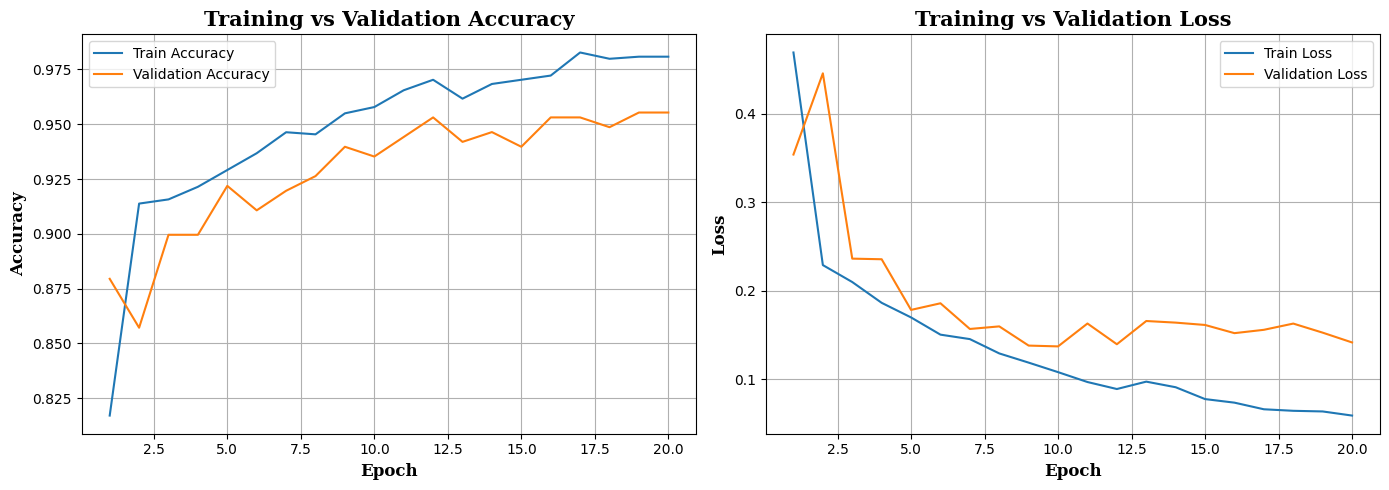

In [28]:
plot(cnn_gru_outputs[0] ,cnn_gru_outputs[1] ,cnn_gru_outputs[2],cnn_gru_outputs[3])

In [29]:
str(cnn_gru_outputs[4]*100) + "%"

'95.78125%'

In [30]:


Y = df['label'].copy()
X = df.drop('label', axis=1).copy()

X = StandardScaler().fit_transform(X)

X_train, x_test, Y_train, y_test = train_test_split(X, Y,random_state=111, test_size=0.3)
X_train, x_val, Y_train, y_val=train_test_split(X_train, Y_train, random_state=111, test_size=0.3)

Y_train = pd.get_dummies(Y_train)
y_test = pd.get_dummies(y_test)
y_val = pd.get_dummies(y_val)


In [31]:
dnn_model = models.Sequential([
    layers.Dense(2548, activation="relu", input_shape=(2548, )),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Dense(3822, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.27),

    layers.Dense(5096, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(3822, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.27),

    layers.Dense(2548, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Dense(3, activation="softmax")
])

dnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2548)           │     6,494,852 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2548)           │        10,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2548)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3822)           │     9,742,278 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 3822)           │        15,288 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 3822)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5096)           │    19,482,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 5096)           │        20,384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3822)           │    19,480,734 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 3822)           │        15,288 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3822)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2548)           │     9,741,004 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2548)           │        10,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2548)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │         7,647 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,019,867 (248.03 MB)

 Trainable params: 64,984,195 (247.90 MB)

 Non-trainable params: 35,672 (139.34 KB)

In [32]:
adam = Adam(learning_rate=0.001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('./best_dnn_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

dnn_model.compile(optimizer=adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])

dnn_h = dnn_model.fit(X_train, Y_train,
                   batch_size=32,
                   validation_data=(x_val, y_val),
                   epochs=50,
                   callbacks=[es, mc, lr_schedule])

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7025 - loss: 2.6871
Epoch 1: val_accuracy improved from -inf to 0.33705, saving model to ./best_dnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 25s 527ms/step - accuracy: 0.7053 - loss: 2.6582 - val_accuracy: 0.3371 - val_loss: 170.4811 - learning_rate: 0.0010
Epoch 2/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8766 - loss: 0.5582
Epoch 2: val_accuracy improved from 0.33705 to 0.51786, saving model to ./best_dnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 308ms/step - accuracy: 0.8777 - loss: 0.5425 - val_accuracy: 0.5179 - val_loss: 42.1047 - learning_rate: 9.0484e-04
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9084 - loss: 0.3175
Epoch 3: val_accuracy improved from 0.51786 to 0.58705, saving model to ./best_dnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 296ms/step - accuracy: 0.9086 - loss: 0.3157 - val_accuracy: 0.5871 - val_loss: 7.6014 - learning_rate: 8.1873e-04
Epoch 4/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9354 - loss: 0.1746
Epoch 4: val_accuracy improved from 0.58705 to 0.88616, saving model to ./best_dnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - accuracy: 0.9356 - loss: 0.1732 - val_accuracy: 0.8862 - val_loss: 0.9009 - learning_rate: 7.4082e-04
Epoch 5/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9480 - loss: 0.1306
Epoch 5: val_accuracy improved from 0.88616 to 0.90848, saving model to ./best_dnn_model.h5


Epoch 6/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9679 - loss: 0.0719
Epoch 6: val_accuracy improved from 0.90848 to 0.92634, saving model to ./best_dnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.9680 - loss: 0.0720 - val_accuracy: 0.9263 - val_loss: 0.2409 - learning_rate: 6.0653e-04
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9814 - loss: 0.0502
Epoch 7: val_accuracy improved from 0.92634 to 0.93750, saving model to ./best_dnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 295ms/step - accuracy: 0.9815 - loss: 0.0500 - val_accuracy: 0.9375 - val_loss: 0.2629 - learning_rate: 5.4881e-04
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9845 - loss: 0.0409
Epoch 8: val_accuracy did not improve from 0.93750
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9844 - loss: 0.0412 - val_accuracy: 0.9353 - val_loss: 0.3696 - learning_rate: 4.9659e-04
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9793 - loss: 0.0594
Epoch 9: val_accuracy did not improve from 0.93750
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9793 - loss: 0.0592 - val_accuracy: 0.9375 - val_loss: 0.2964 - learning_rate: 4.4933e-04
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9858 - loss: 0.0410
Epoch 10: val_accuracy improved from 0.93750 to 0.94643, saving model to ./best_dnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 179ms/step - accuracy: 0.9858 - loss: 0.0408 - val_accuracy: 0.9464 - val_loss: 0.2369 - learning_rate: 4.0657e-04
Epoch 11/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9906 - loss: 0.0265
Epoch 11: val_accuracy did not improve from 0.94643
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9906 - loss: 0.0270 - val_accuracy: 0.9420 - val_loss: 0.2712 - learning_rate: 3.6788e-04
Epoch 12/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9804 - loss: 0.0487
Epoch 12: val_accuracy improved from 0.94643 to 0.95982, saving model to ./best_dnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 19s 582ms/step - accuracy: 0.9807 - loss: 0.0477 - val_accuracy: 0.9598 - val_loss: 0.2079 - learning_rate: 3.3287e-04
Epoch 13/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9930 - loss: 0.0170
Epoch 13: val_accuracy did not improve from 0.95982
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9930 - loss: 0.0171 - val_accuracy: 0.9576 - val_loss: 0.1860 - learning_rate: 3.0119e-04
Epoch 14/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9948 - loss: 0.0130
Epoch 14: val_accuracy improved from 0.95982 to 0.96875, saving model to ./best_dnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 318ms/step - accuracy: 0.9949 - loss: 0.0128 - val_accuracy: 0.9688 - val_loss: 0.1513 - learning_rate: 2.7253e-04
Epoch 15/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9978 - loss: 0.0068
Epoch 15: val_accuracy did not improve from 0.96875
33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.9978 - loss: 0.0067 - val_accuracy: 0.9688 - val_loss: 0.1440 - learning_rate: 2.4660e-04
Epoch 16/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0027
Epoch 16: val_accuracy did not improve from 0.96875
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.0000 - loss: 0.0027 - val_accuracy: 0.9665 - val_loss: 0.1507 - learning_rate: 2.2313e-04
Epoch 17/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0033
Epoch 17: val_accuracy improved from 0.96875 to 0.97321, saving model to ./best_dnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 653ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.9732 - val_loss: 0.1498 - learning_rate: 2.0190e-04
Epoch 18/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0018
Epoch 18: val_accuracy did not improve from 0.97321
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9732 - val_loss: 0.1485 - learning_rate: 1.8268e-04
Epoch 19/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0014
Epoch 19: val_accuracy did not improve from 0.97321
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9710 - val_loss: 0.1511 - learning_rate: 1.6530e-04
Epoch 20/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0013
Epoch 20: val_accuracy did not improve from 0.97321
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9710 - val_loss: 0.1526 - learning_rate: 1.4957e-04
Epoch 21

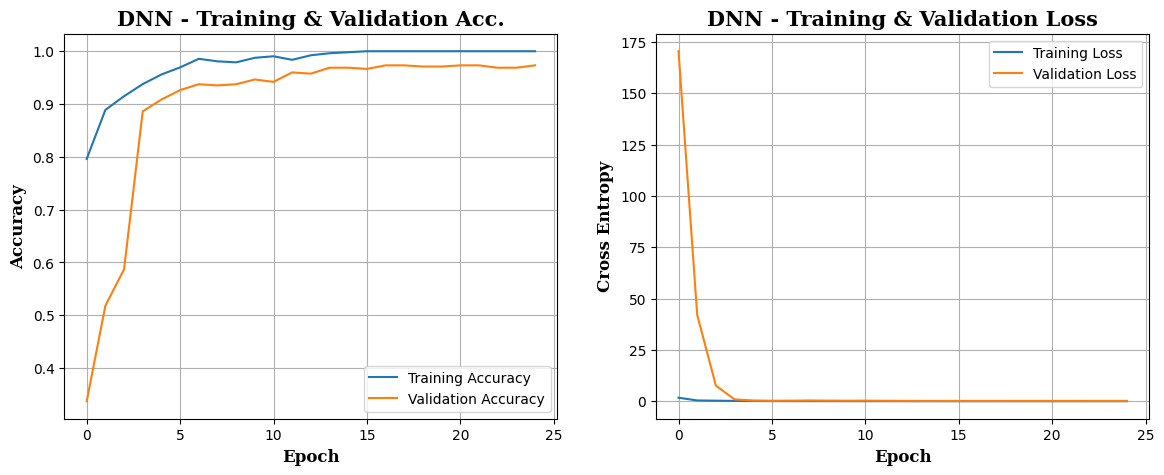

In [33]:
fontdict1 = {"family":"Serif", "size": 12, "weight":"bold"}
fontdict2 = {"family":"Serif", "size": 15, "weight":"bold"}

acc = dnn_h.history['accuracy']
val_acc = dnn_h.history['val_accuracy']

loss = dnn_h.history['loss']
val_loss = dnn_h.history['val_loss']


plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy',fontdict=fontdict1)
plt.title('DNN - Training & Validation Acc.', fontdict = fontdict2)
plt.xlabel('Epoch', fontdict = fontdict1)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylabel('Cross Entropy', fontdict=fontdict1)
plt.title('DNN - Training & Validation Loss', fontdict=fontdict2)
plt.xlabel('Epoch', fontdict=fontdict1)
plt.legend()
plt.grid(True)

plt.show()

In [34]:
dnn_best = models.load_model('./best_dnn_model.h5')
dnn_acc = dnn_best.evaluate(x_test, y_test, verbose=0)[1]
print(f"Test Acc. DNN: {dnn_acc * 100:.3f}%")

Test Acc. DNN: 96.562%


In [35]:
def build_paper_cnn(input_length, n_classes=3):
    model = models.Sequential()

    # Conv layers like in the paper
    model.add(layers.Conv1D(filters=32, kernel_size=3, padding="same",
                            activation="relu", input_shape=(input_length, 1)))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))

    model.add(layers.Conv1D(filters=64, kernel_size=3, padding="same",
                            activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))

    model.add(layers.Conv1D(filters=128, kernel_size=3, padding="same",
                            activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling1D(pool_size=2))

    # Flatten + fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation="relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(n_classes, activation="softmax"))

    return model

# Example usage:
input_length = 2548   # your EEG sequence length
n_classes = 3         # number of target classes
cnn_model = build_paper_cnn(input_length, n_classes)
cnn_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2548, 32)       │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 2548, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1274, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1274, 64)       │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1274, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 637, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 637, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 637, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 318, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40704)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 40704)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    10,420,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,453,187 (39.88 MB)

 Trainable params: 10,452,739 (39.87 MB)

 Non-trainable params: 448 (1.75 KB)

In [36]:
adam = Adam(learning_rate=0.001)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)
mc = ModelCheckpoint('./best_cnn_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
lr_schedule = LearningRateScheduler(lambda epoch: 0.001 * np.exp(-epoch / 10.))

cnn_model.compile(optimizer=adam,
                  loss=['categorical_crossentropy'],
                  metrics=['accuracy'])

cnn_h = cnn_model.fit(X_train, Y_train,
                   batch_size=32,
                   validation_data=(x_val, y_val),
                   epochs=50,
                   callbacks=[es, mc, lr_schedule])

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.7472 - loss: 5.9927
Epoch 1: val_accuracy improved from -inf to 0.37277, saving model to ./best_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 187ms/step - accuracy: 0.7499 - loss: 5.9099 - val_accuracy: 0.3728 - val_loss: 8.1471 - learning_rate: 0.0010
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9267 - loss: 0.5174
Epoch 2: val_accuracy did not improve from 0.37277
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9268 - loss: 0.5154 - val_accuracy: 0.3594 - val_loss: 25.3517 - learning_rate: 9.0484e-04
Epoch 3/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9625 - loss: 0.2699
Epoch 3: val_accuracy did not improve from 0.37277
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9627 - loss: 0.2639 - val_accuracy: 0.3504 - val_loss: 31.2908 - learning_rate: 8.1873e-04
Epoch 4/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9678 - loss: 0.1797
Epoch 4: val_accuracy did not improve from 0.37277
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9681 - loss: 0.1761 - val_accuracy: 0.3571 - val_loss: 43.0048 - learning_rate: 7.4082e-04
Epoch 5/50
31/3

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.9926 - loss: 0.0462 - val_accuracy: 0.3795 - val_loss: 39.8157 - learning_rate: 6.0653e-04
Epoch 7/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9862 - loss: 0.0976
Epoch 7: val_accuracy improved from 0.37946 to 0.40848, saving model to ./best_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9862 - loss: 0.0945 - val_accuracy: 0.4085 - val_loss: 28.7990 - learning_rate: 5.4881e-04
Epoch 8/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9889 - loss: 0.0904
Epoch 8: val_accuracy improved from 0.40848 to 0.49777, saving model to ./best_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9890 - loss: 0.0894 - val_accuracy: 0.4978 - val_loss: 20.5983 - learning_rate: 4.9659e-04
Epoch 9/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9940 - loss: 0.0361
Epoch 9: val_accuracy improved from 0.49777 to 0.58036, saving model to ./best_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.9939 - loss: 0.0357 - val_accuracy: 0.5804 - val_loss: 16.1958 - learning_rate: 4.4933e-04
Epoch 10/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9930 - loss: 0.0250
Epoch 10: val_accuracy improved from 0.58036 to 0.76116, saving model to ./best_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.9930 - loss: 0.0249 - val_accuracy: 0.7612 - val_loss: 7.8746 - learning_rate: 4.0657e-04
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9905 - loss: 0.0280
Epoch 11: val_accuracy improved from 0.76116 to 0.81027, saving model to ./best_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9906 - loss: 0.0280 - val_accuracy: 0.8103 - val_loss: 4.2106 - learning_rate: 3.6788e-04
Epoch 12/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9935 - loss: 0.0319
Epoch 12: val_accuracy improved from 0.81027 to 0.86607, saving model to ./best_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9935 - loss: 0.0313 - val_accuracy: 0.8661 - val_loss: 2.3713 - learning_rate: 3.3287e-04
Epoch 13/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9957 - loss: 0.0137
Epoch 13: val_accuracy improved from 0.86607 to 0.91964, saving model to ./best_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.9957 - loss: 0.0134 - val_accuracy: 0.9196 - val_loss: 1.2928 - learning_rate: 3.0119e-04
Epoch 14/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9993 - loss: 0.0042
Epoch 14: val_accuracy improved from 0.91964 to 0.94643, saving model to ./best_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.9993 - loss: 0.0044 - val_accuracy: 0.9464 - val_loss: 0.8722 - learning_rate: 2.7253e-04
Epoch 15/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9962 - loss: 0.0065
Epoch 15: val_accuracy improved from 0.94643 to 0.95536, saving model to ./best_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9963 - loss: 0.0065 - val_accuracy: 0.9554 - val_loss: 0.6374 - learning_rate: 2.4660e-04
Epoch 16/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9995 - loss: 0.0077
Epoch 16: val_accuracy improved from 0.95536 to 0.96205, saving model to ./best_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9993 - loss: 0.0089 - val_accuracy: 0.9621 - val_loss: 0.5442 - learning_rate: 2.2313e-04
Epoch 17/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9990 - loss: 0.0018
Epoch 17: val_accuracy improved from 0.96205 to 0.96429, saving model to ./best_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9990 - loss: 0.0018 - val_accuracy: 0.9643 - val_loss: 0.4755 - learning_rate: 2.0190e-04
Epoch 18/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9990 - loss: 0.0019
Epoch 18: val_accuracy did not improve from 0.96429
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9989 - loss: 0.0020 - val_accuracy: 0.9643 - val_loss: 0.4249 - learning_rate: 1.8268e-04
Epoch 19/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9998 - loss: 0.0027
Epoch 19: val_accuracy improved from 0.96429 to 0.96875, saving model to ./best_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9997 - loss: 0.0031 - val_accuracy: 0.9688 - val_loss: 0.3594 - learning_rate: 1.6530e-04
Epoch 20/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9991 - loss: 0.0013
Epoch 20: val_accuracy improved from 0.96875 to 0.97098, saving model to ./best_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9991 - loss: 0.0013 - val_accuracy: 0.9710 - val_loss: 0.3353 - learning_rate: 1.4957e-04
Epoch 21/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9999 - loss: 0.0017
Epoch 21: val_accuracy did not improve from 0.97098
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9999 - loss: 0.0019 - val_accuracy: 0.9710 - val_loss: 0.3247 - learning_rate: 1.3534e-04
Epoch 22/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9966 - loss: 0.0085
Epoch 22: val_accuracy improved from 0.97098 to 0.97321, saving model to ./best_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9965 - loss: 0.0089 - val_accuracy: 0.9732 - val_loss: 0.3041 - learning_rate: 1.2246e-04
Epoch 23/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9983 - loss: 0.0540
Epoch 23: val_accuracy did not improve from 0.97321
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9983 - loss: 0.0539 - val_accuracy: 0.9732 - val_loss: 0.2191 - learning_rate: 1.1080e-04
Epoch 24/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0010
Epoch 24: val_accuracy improved from 0.97321 to 0.97545, saving model to ./best_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9754 - val_loss: 0.2124 - learning_rate: 1.0026e-04
Epoch 25/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9993 - loss: 0.0028
Epoch 25: val_accuracy improved from 0.97545 to 0.97991, saving model to ./best_cnn_model.h5


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9993 - loss: 0.0029 - val_accuracy: 0.9799 - val_loss: 0.2047 - learning_rate: 9.0718e-05
Epoch 26/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9988 - loss: 0.0023
Epoch 26: val_accuracy did not improve from 0.97991
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9988 - loss: 0.0022 - val_accuracy: 0.9754 - val_loss: 0.2021 - learning_rate: 8.2085e-05
Epoch 27/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 1.0000 - loss: 5.9645e-04
Epoch 27: val_accuracy did not improve from 0.97991
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 1.0000 - loss: 6.0718e-04 - val_accuracy: 0.9754 - val_loss: 0.2027 - learning_rate: 7.4274e-05
Epoch 28/50
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9982 - loss: 0.0027
Epoch 28: val_accuracy did not improve from 0.97991
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9983 - loss: 0.0027 - val_accuracy: 0.9754 - val_loss: 0.2036 - learning_rate: 6.7206e-05
Ep

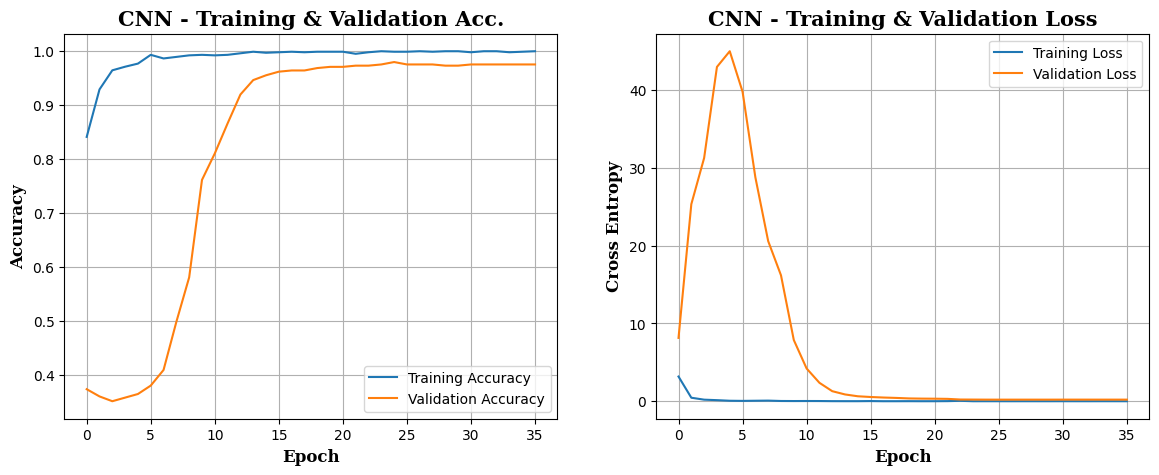

In [37]:
fontdict1 = {"family":"Serif", "size": 12, "weight":"bold"}
fontdict2 = {"family":"Serif", "size": 15, "weight":"bold"}

acc = cnn_h.history['accuracy']
val_acc = cnn_h.history['val_accuracy']

loss = cnn_h.history['loss']
val_loss = cnn_h.history['val_loss']


plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy',fontdict=fontdict1)
plt.title('CNN - Training & Validation Acc.', fontdict = fontdict2)
plt.xlabel('Epoch', fontdict = fontdict1)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylabel('Cross Entropy', fontdict=fontdict1)
plt.title('CNN - Training & Validation Loss', fontdict=fontdict2)
plt.xlabel('Epoch', fontdict=fontdict1)
plt.legend()
plt.grid(True)

plt.show()

In [38]:
cnn_best = models.load_model('./best_cnn_model.h5')
cnn_acc = cnn_best.evaluate(x_test, y_test, verbose=0)[1]
print(f"Test Acc. CNN: {cnn_acc * 100:.3f}%")

Test Acc. CNN: 97.812%


In [39]:
new_df = pd.DataFrame({
    "model": ["CNN", "LSTM", "GRU", "DNN", "CNN+LSTM", "CNN+GRU"],
    "Accuracy": [
        f"{cnn_acc*100:.3f}%",
        f"{lstm_outputs[4]*100:.3f}%",
        f"{gru_outputs[4]*100:.3f}%",
        f"{dnn_acc*100:.3f}%",
        f"{cnn_lstm_outputs[4]*100:.3f}%",
        f"{cnn_gru_outputs[4]*100:.3f}%"
    ]
})


In [40]:
new_df

,model,Accuracy
0,CNN,97.812%
1,LSTM,97.812%
2,GRU,97.812%
3,DNN,96.562%
4,CNN+LSTM,94.531%
5,CNN+GRU,95.781%


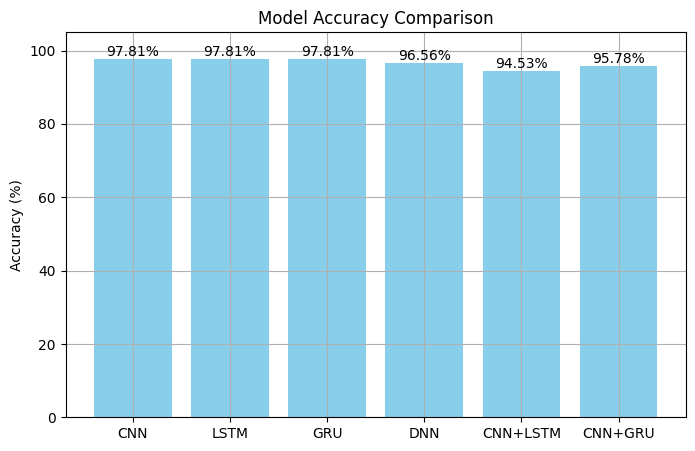

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

new_df = pd.DataFrame({
    "model": ["CNN", "LSTM", "GRU", "DNN", "CNN+LSTM", "CNN+GRU"],
    "Accuracy": [
        cnn_acc*100,
        lstm_outputs[4]*100,
        gru_outputs[4]*100,
        dnn_acc*100,
        cnn_lstm_outputs[4]*100,
        cnn_gru_outputs[4]*100
    ]
})


plt.figure(figsize=(8,5))
bars = plt.bar(new_df["model"], new_df["Accuracy"], color="skyblue")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{height:.2f}%",
        ha="center", va="bottom"
    )

plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison")
plt.ylim(0, 105)
plt.grid(True)
plt.show()
